In [3]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import skimage.io
from scipy.ndimage import median_filter
from scipy import signal
from scipy.ndimage import sobel
from scipy import ndimage
from skimage import exposure
import multipagetiff as mtif
# import cloudComPy as cc
# from n2v.models import N2VConfig, N2V
# from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
# from csbdeep.utils import plot_history
# from n2v.utils.n2v_utils import manipulate_val_data, autocorrelation
# from google.colab.patches import cv2_imshow
# from google.colab import drive
import pyvista as pv
from pyntcloud import PyntCloud
import os
from skimage.filters import threshold_otsu
from PIL import Image
from skimage import io

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


* jpeg on each layer
* different quality
* check distortion and bitrate
* distortion is root meansquare error
---
* check median filter on single layer and and across layers and see performance
* 

s - number of slices
i, j  - rows and columns of each image
mean or median value along each slice
projections along rows and columns also
3 types of projections
bands of



* show code for code
* 

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
###################################################################
This Source Code Form is subject to the terms of the Mozilla Public
License, v. 2.0. If a copy of the MPL was not distributed with this
file, You can obtain one at https://mozilla.org/MPL/2.0/.

copyright (c) 2020, Peter Szutor

@author: Peter Szutor, Hungary, szppaks@gmail.com
Created on Wed Feb 26 17:23:24 2020
###################################################################



Octree-based lossy point-cloud compression with open3d and numpy
Average compressing rate (depends on octreee depth setting parameter): 0.012 - 0.1


Input formats: You can get a list of supported formats from : http://www.open3d.org/docs/release/tutorial/Basic/file_io.html#point-cloud
               (xyz,pts,ply,pcd)

Usage:

Dependencies: Open3D, Numpy  (You can install theese modules:  pip install open3d, pip install numpy)

Compress a point cloud:

octreezip(<filename>,<depth>) -> <result>
<filename>: (str) Point Cloud file name. Saved file name: [filename without ext]_ocz.npz  (Yes, it's a numpy array file)
<depth>   : (str) Octree depth. You can try 11-16 for best result. Bigger depht results higher precision and bigger compressed file size.
<result>  : (str) If the compressing was success you get: "Compressed into:[comp.file name] | Storing resolution:0.003445". Storing resolution means the precision.
                  The PC file is missing or bad: "PC is empty, bad, or missing"
                  Other error: "Error: [error message]"


Uncompressing:
octreeunzip(<filename>) -> <result>
<filename>: (str) Zipped Point Cloud file name (npz). Saved file name: [filename].xyz  (standard XYZ text file)
<result>  : (str) If the compressing was success you get: "Saved: [filename].xyz"
                  Other error: "Error: [error message]"
"""
def d1halfing_fast(pmin,pmax,pdepht):
    return np.linspace(pmin,pmax,2**int(pdepht)+1)

def octreecodes(ppoints,pdepht):
    minx=np.amin(ppoints[:,0])
    maxx=np.amax(ppoints[:,0])
    miny=np.amin(ppoints[:,1])
    maxy=np.amax(ppoints[:,1])
    minz=np.amin(ppoints[:,2])
    maxz=np.amax(ppoints[:,2])
    xletra=d1halfing_fast(minx,maxx,pdepht)
    yletra=d1halfing_fast(miny,maxy,pdepht)
    zletra=d1halfing_fast(minz,maxz,pdepht)
    otcodex=np.searchsorted(xletra,ppoints[:,0],side='right')-1
    otcodey=np.searchsorted(yletra,ppoints[:,1],side='right')-1
    otcodez=np.searchsorted(zletra,ppoints[:,2],side='right')-1
    ki=otcodex*(2**(pdepht*2))+otcodey*(2**pdepht)+otcodez
    return (ki,minx,maxx,miny,maxy,minz,maxz)

def octreezip(pfilename,pdepht):
    try:
        pcd = o3d.io.read_point_cloud(pfilename,format='auto')
        ppoints=np.asarray(pcd.points)
        if len(ppoints)>0:
            occ=octreecodes(ppoints,pdepht)
            occsorted=np.sort(occ[0])
            prec=np.amax(np.asarray([occ[2]-occ[1],occ[4]-occ[3],occ[6]-occ[5]])/(2**pdepht))
            paramarr=np.asarray([pdepht,occ[1],occ[2],occ[3],occ[4],occ[5],occ[6]]) #depth and boundary
            np.savez_compressed(os.path.splitext(pfilename)[0]+'_ocz',points=occsorted,params=paramarr)
            retmessage='Compressed into:'+str(os.path.splitext(pfilename)[0])+'.ocz | Storing resolution:'+str(prec)
        else:
            retmessage='PC is empty, bad, or missing'
    except Exception as e:
        retmessage='Error:'+str(e)
    return retmessage

def octreeunzip(pfilename):
    try:
        pc=np.load(pfilename)
        pcpoints=pc['points']
        pcparams=pc['params']
        pdepht=(pcparams[0])
        minx=(pcparams[1])
        maxx=(pcparams[2])
        miny=(pcparams[3])
        maxy=(pcparams[4])
        minz=(pcparams[5])
        maxz=(pcparams[6])
        xletra=d1halfing_fast(minx,maxx,pdepht)
        yletra=d1halfing_fast(miny,maxy,pdepht)
        zletra=d1halfing_fast(minz,maxz,pdepht)
        occodex=(pcpoints/(2**(pdepht*2))).astype(int)
        occodey=((pcpoints-occodex*(2**(pdepht*2)))/(2**pdepht)).astype(int)
        occodez=(pcpoints-occodex*(2**(pdepht*2))-occodey*(2**pdepht)).astype(int)
        koorx=xletra[occodex]
        koory=yletra[occodey]
        koorz=zletra[occodez]
        points=np.array([koorx,koory,koorz]).T
        np.savetxt(os.path.splitext(pfilename)[0]+'.xyz',points,fmt='%.4f')
        retmessage='Saved:'+os.path.splitext(pfilename)[0]+'.xyz'
    except Exception as e:
        retmessage='Error:'+str(e)
    return retmessage

# Save the point cloud
def compress_ratio(point_cloud, name):
  o3d.io.write_point_cloud(name + ".ply", point_cloud) # save point cloud
  octreezip(name + '.ply', 5) # compress point cloud
  orig_size = os.path.getsize(name + '.ply')
  compressed_size = os.path.getsize(name + '_ocz.npz')
  ratio = compressed_size/orig_size
  return ratio

def binarise(images):
  image_stack= np.array(images)

  # Get the shape of the image stack
  depth, height, width = image_stack.shape

  # Reshape the image stack into a single 2D image
  combined_image = image_stack.reshape(depth * height, width)

  gray_image = combined_image

  # Compute Otsu's threshold for the combined image
  threshold = threshold_otsu(gray_image)

  # Apply the threshold to the combined image
  thresholded_image = gray_image > threshold

  # Reshape the thresholded image back into a 3D stack
  thresholded_stack = thresholded_image.reshape(depth, height, width)
  return thresholded_stack

def makepcl(binary_images):
    # Extract pixel coordinates and map them to 3D space
    coords = []
    for i, image in enumerate(binary_images):
        coords_i = np.column_stack(np.where(image > 0))
        coords_i = np.hstack((coords_i, np.full((coords_i.shape[0], 1), -i)))  # Mapping to Z-coordinate
        coords.append(coords_i)

    # Combine the pixel coordinates from all images
    all_coords = np.concatenate(coords)

    # Scale and normalize the coordinates
    scale_factor_z = 3  # Adjust the scale factor for the z-axis as needed
    all_coords[:, 2] = all_coords[:, 2] * scale_factor_z

    # Calculate the center of the point cloud
    center = np.mean(all_coords, axis=0)

    # Translate the coordinates to center the point cloud
    all_coords[:, 0] = all_coords[:, 0] - center[0]
    all_coords[:, 1] = all_coords[:, 1] - center[1]
    all_coords[:, 2] = all_coords[:, 2] - center[2]

    # Create a point cloud
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(all_coords[:, [1, 0, 2]])  # Swap X and Y axes for Open3D
    return point_cloud

def pcl_to_stack(point_cloud, scale_factor_z=3):
    # Extract the coordinates from the point cloud
    coords = np.asarray(point_cloud.points)
    coords = coords[:, [1, 0, 2]]  # Swap X and Y axes for Open3D

    # Calculate the center of the point cloud
    center = np.mean(coords, axis=0)

    # Translate the coordinates to center the point cloud
    coords[:, 0] = coords[:, 0] + center[0]
    coords[:, 1] = coords[:, 1] + center[1]
    coords[:, 2] = coords[:, 2] + center[2]

    # Scale and normalize the coordinates
    coords[:, 2] = coords[:, 2] / scale_factor_z

    # Round the Z-coordinates to get the image indices
    image_indices = np.round(coords[:, 2]).astype(int)

    # Create a list of binary images
    binary_images = []
    for i in range(image_indices.min(), image_indices.max() + 1):
        image_coords = coords[image_indices == i][:, :2]
        image_coords = np.round(image_coords).astype(int)
        max_x, max_y = image_coords.max(axis=0)
        binary_image = np.zeros((max_x + 1, max_y + 1), dtype=bool)
        binary_image[image_coords[:, 0], image_coords[:, 1]] = True
        binary_images.append(binary_image)

    return binary_images

# Save the image
def jpeg_compress_ratios(images): # stack of images as numpy array
    big_ratio_arr = []
    big_quality_arr = []
    for img in images:
        # Rescale the pixel values of the image to the range [0, 255]
        image_array = img
        image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255
        image_array = image_array.astype(np.uint8)

        # Convert the NumPy array to a PIL Image
        image = Image.fromarray(image_array)

        # Convert the image to 8-bit mode
        image = image.convert('L')

       
        io.imsave('orig.png', img) # change to img
        orig_size = os.path.getsize('orig.png')
        
        # Save the image in JPEG format at different levels of compression
        ratio_arr = []
        quality_arr = []
        for quality in range(10, 96, 5):
            image.save(f'image_{quality}.jpg', 'JPEG', quality=quality)
            size = os.path.getsize(f'image_{quality}.jpg')
            ratio_arr.append(size/orig_size)
            
            orig = cv2.imread('orig.png')
            # os.remove('orig.png')
            curr = cv2.imread(f'image_{quality}.jpg')
            os.remove(f'image_{quality}.jpg')
            rmse = cv2.norm(orig, curr, cv2.NORM_L2) / np.sqrt(orig.size)
            quality_arr.append(rmse)
        big_ratio_arr.append(ratio_arr)
        big_quality_arr.append(quality_arr)
    return big_ratio_arr, big_quality_arr

def plot_jpeg_compression_results(ratios, qualities):
    # Create a new figure
    fig, ax1 = plt.subplots()
    
    # Plot the compression ratios on the left y-axis
    ax1.set_xlabel('JPEG Quality')
    ax1.set_ylabel('Compression Ratio')
    for ratio in ratios:
        ax1.plot(range(10, 96, 5), ratio, color='tab:blue')
    
    # Create a twin y-axis that shares the x-axis
    ax2 = ax1.twinx()
    
    # Plot the RMSE values on the right y-axis
    ax2.set_ylabel('RMSE')
    for quality in qualities:
        ax2.plot(range(10, 96, 5), quality, color='tab:orange')
    
    # Show the plot
    plt.show()

def jacobian(image):
    # Convert image to grayscale if it is RGB
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    
    # Calculate the gradients in x and y directions
    Ix, Iy = np.gradient(image)
    
    # Calculate the Jacobian
    jacobian = np.array([[Ix * Ix, Ix * Iy, Iy * Ix, Iy * Iy]])
    
    return jacobian

def jacobian_3d(image_stack):
    # Calculate the gradients of the image stack along each axis
    dx = sobel(image_stack, axis=0, mode='constant')
    dy = sobel(image_stack, axis=1, mode='constant')
    dz = sobel(image_stack, axis=2, mode='constant')

    # Initialize the Jacobian matrix
    jacobian = np.zeros((image_stack.shape[0], image_stack.shape[1], image_stack.shape[2], 3, 3))

    # Fill in the values of the Jacobian matrix
    jacobian[..., 0, 0] = dx
    jacobian[..., 0, 1] = dy
    jacobian[..., 0, 2] = dz
    jacobian[..., 1, 0] = dx
    jacobian[..., 1, 1] = dy
    jacobian[..., 1, 2] = dz
    jacobian[..., 2, 0] = dx
    jacobian[..., 2, 1] = dy
    jacobian[..., 2, 2] = dz

    return jacobian

def visualize_jacobian(jacobian, vmin=None, vmax=None):
    # Compute the magnitude of the Jacobian matrix along the last two axes
    jacobian_magnitude = np.linalg.norm(jacobian, axis=(-2, -1))

    # Plot each slice of the resulting 3D array as a separate image
    for i in range(jacobian_magnitude.shape[0]):
        plt.figure()
        plt.imshow(jacobian_magnitude[i], vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title(f'Slice {i}')
        plt.show()

def visualize_jacobian_normal(jacobian):
    # Compute the magnitude of the Jacobian matrix along the last two axes
    jacobian_magnitude = np.linalg.norm(jacobian, axis=(-2, -1))

    # Plot each slice of the resulting 3D array as a separate image
    for i in range(jacobian_magnitude.shape[0]):
        plt.figure()
        plt.imshow(jacobian_magnitude[i], cmap='hot')
        plt.colorbar()
        plt.title(f'Slice {i}')
        plt.show()

def apply_operator(image, kernel_size, modifier):
    assert kernel_size % 2 == 1, "Kernel size must be odd"
    kernel = np.ones((kernel_size, kernel_size))
    kernel[kernel_size // 2, kernel_size // 2] = 0
    convolved = ndimage.convolve(image, kernel, mode='constant', cval=0)
    result = image - convolved * modifier
    return result

def apply_operator_3d(image, kernel_size, modifier):
    assert kernel_size % 2 == 1, "Kernel size must be odd"
    kernel = np.ones((kernel_size, kernel_size, kernel_size))
    kernel[kernel_size // 2, kernel_size // 2, kernel_size // 2] = 0
    convolved = ndimage.convolve(image, kernel, mode='constant', cval=0)
    result = image - convolved * modifier
    return result

def reduce_row(image, n):
    result = np.zeros_like(image)
    for i, row in enumerate(image):
        idx = np.argpartition(row, -n)[-n:]
        result[i, idx] = row[idx]
    return result



jpeg blur on stack of images:
  - take each img and compress at different levels of compression
    - note the different levels of compression against mse distortion 
  - take the average of the distortion curves

pcl compression:
  - compress with pretrained model

https://cloudconvert.com/tif-to-jpg

* https://ieeexplore.ieee.org/document/8954066
* https://octave.org/
* https://github.com/cloudcompare/cloudcompare / https://www.danielgm.net/cc/
* https://scholar.google.com/scholar?oi=bibs&hl=en&cites=14009452987874973669&authuser=1
* https://pointclouds.org/documentation/classpcl_1_1_morphology.html
* https://scholar.google.com/scholar?hl=en&as_sdt=2005&sciodt=0%2C5&cites=9800399061227290708&scipsc=1&q=pointclouds&authuser=1

checked
--- 
* https://arxiv.org/pdf/2206.03977v1.pdf
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html
* https://projecteuclid.org/journals/duke-mathematical-journal/volume-8/issue-2/Riemannian-manifolds-with-positive-mean-curvature/10.1215/S0012-7094-41-00832-3.short
* https://inside.mines.edu/~whereman/papers/delaPorte-Herbst-Hereman-vanderWalt-PRASA-2008.pdf

* temporal median
* non maximal supression to extract internal intestine
* edge detection for worm body (for body on each slice)

In [6]:
images = mtif.read_stack("testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40%_EM-4_D2_3_7047.tif", units='um')
# images = mtif.read_stack("testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40%_EM-4_D2_3_7048.tif", units='um')
# images = mtif.read_stack("testimages/2022.12.21_APS018_Infection_PA14-GacA_40X_40%_EM-4_D2_3_7046.tif", units='um')

images = np.array(images)

In [89]:
nvm_2d = []
for img in images:
  nvm_2d.append(apply_operator(img, 3, 0.01))

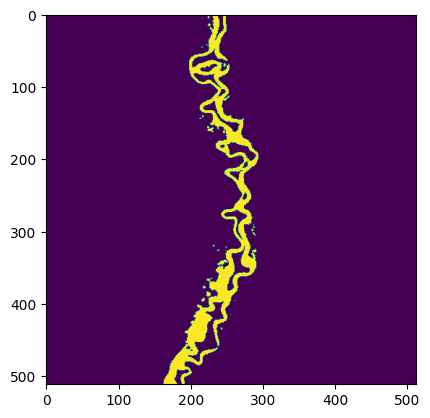

In [350]:
plt.imshow(binarise(nvm_2d)[7])

In [166]:
cross_sections = []
for i in range(images.shape[1]):
  cross_sections.append(np.take(images, i, axis=1))

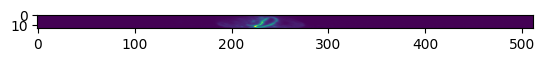

In [167]:
plt.imshow(cross_sections[0])

In [340]:
csr = []
for cs in cross_sections:
  csr.append(apply_operator(cs, 11, 0.01)) 

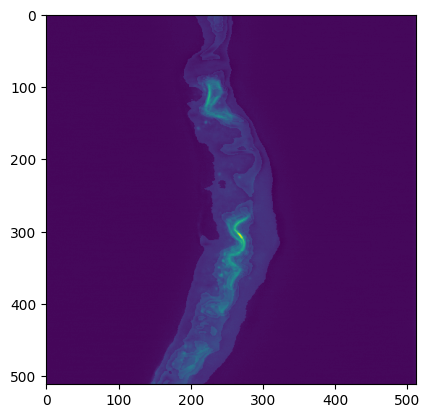

In [341]:
plt.imshow(np.take(csr,0, axis=1))

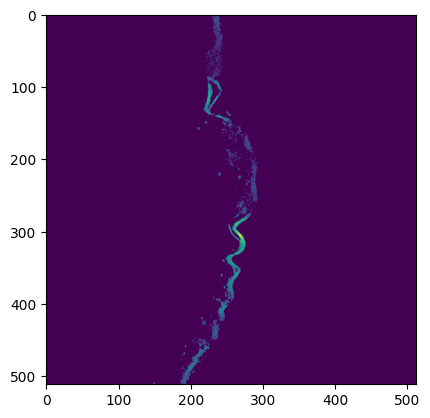

In [308]:
from skimage import feature
cs_edges = []
for cs in csr:
  edges = feature.canny(cs, sigma=7.0, low_threshold=1, high_threshold=1001)
  cs_edges.append(edges)

In [159]:
nms_cs = []
for cs in cross_sections:
  nms_cs.append(apply_operator(cs, 3, 0.04))
nms_cs = np.array(nms_cs)

In [161]:
bin_nms_cs = binarise(nms_cs)

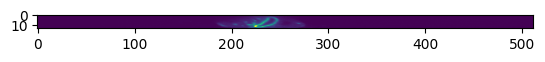

In [292]:
# axis 0 is RC
# axis 1 is RS
# axis 2 is CS
plt.imshow(np.take(images, 4, axis=1))

In [293]:
binarised = binarise(images)

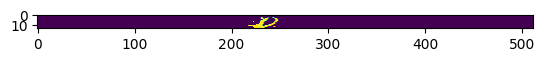

In [162]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Set the initial image
# im = ax.imshow(np.take(bin_nms_cs, 0, axis=0))

# # Define the update function
# def update(i):
#     im.set_data(np.take(bin_nms_cs, i, axis=0))

# # Create the animation
# ani = FuncAnimation(fig, update, frames=range(bin_nms_cs.shape[0]), interval=50)

# from matplotlib.animation import PillowWriter

# # Set up the writer
# writer = PillowWriter(fps=60)

# # Save the animation
# ani.save('nms_cs.gif', writer=writer)

In [297]:
# rc_binarised = np.mean(binarised, axis=0)
# import imageio
# imageio.imwrite('binarised_cross.png', rc_binarised)

In [225]:
# rc_mean = np.mean(images, axis=0)
# rs_mean = np.mean(images, axis=1)
# cs_mean = np.mean(images, axis=2)

# import imageio

# # Save the images
# imageio.imsave('rc_mean_3.png', rc_mean)
# imageio.imsave('rs_mean_3.png', rs_mean)
# imageio.imsave('cs_mean_3.png', cs_mean)

In [226]:
binary_images_0 = binarise(images)
x_0 = makepcl(binary_images_0)
compress_ratio(x_0, 'x_0')

0.0024181272497048345

In [180]:
images = np.array(images)
np_images = np.stack(images, axis=2)
np_equalised_images = exposure.equalize_adapthist(np_images, clip_limit=0.03)
equalised_images = np.split(np_equalised_images, np_equalised_images.shape[2], axis=2)
equalised_images = [np.squeeze(img) for img in equalised_images]

In [181]:
# As we can see, equalisation,does not actually reduce noise just improves visibility for us
binary_images_1 = binarise(images)
x_1 = makepcl(binary_images_1)
compress_ratio(x_1, 'x_1')

0.0028460313170867624

In [186]:
eq_images = np.stack(images, axis=2)
med_blur_images_numpyarray = signal.medfilt(eq_images, kernel_size=(7,7,7))
med_blur_images = np.split(med_blur_images_numpyarray, med_blur_images_numpyarray.shape[2], axis=2)
med_blur_images = [np.squeeze(img) for img in med_blur_images]
# med_blur_images = images

In [232]:
med_blur_images = np.array(med_blur_images)

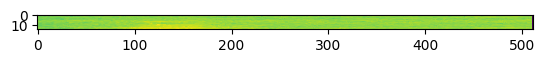

In [233]:
# Create a figure and axis
fig, ax = plt.subplots()

# Set the initial image
im = ax.imshow(np.take(med_blur_images, 0, axis=1))

# Define the update function
def update(i):
    im.set_data(np.take(med_blur_images, i, axis=1))

# Create the animation
ani = FuncAnimation(fig, update, frames=range(med_blur_images.shape[1]), interval=50)

from matplotlib.animation import PillowWriter

# Set up the writer
writer = PillowWriter(fps=15)

# Save the animation
ani.save('animationmed2.gif', writer=writer)



In [207]:
binary_images_2 = binarise(med_blur_images)
x_2 = makepcl(binary_images_2)
compress_ratio(x_2, 'x_2')

0.0023058737083682668

In [208]:
def convert_float64_to_uint8(float64_images):
    uint8_images = []
    for float64_image in float64_images:
        # Normalize pixel values to the range [0, 255]
        norm_image = ((float64_image - float64_image.min()) / (float64_image.max() - float64_image.min())) * 255
        # Convert data type to uint8
        uint8_image = norm_image.astype(np.uint8)
        uint8_images.append(uint8_image)
    return uint8_images

uint8_med_blur = convert_float64_to_uint8(med_blur_images)

In [209]:
# kernel_size = 3
# kernel = cv2.getStructuringElement(cv2.MORPH_OPEN, (kernel_size, kernel_size))

# # Apply morphological closing operation to each binary image
# closed_images = []
# for bin_img in binary_images_2:
#     bin_img_uint8 = (bin_img * 255).astype(np.uint8)
#     closed_img = cv2.morphologyEx(bin_img_uint8, cv2.MORPH_OPEN, kernel, iterations=3)
#     closed_images.append(closed_img)

kernel_size = 3
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

# Apply erosion operation to each binary image
eroded_images = []
for bin_img in binary_images_2:
    bin_img_uint8 = (bin_img * 255).astype(np.uint8)
    eroded_img = cv2.erode(bin_img_uint8, kernel, iterations=0)
    eroded_images.append(eroded_img)


In [210]:
# binary_images_3 = binarise(closed_images)
binary_images_3 = binarise(eroded_images)


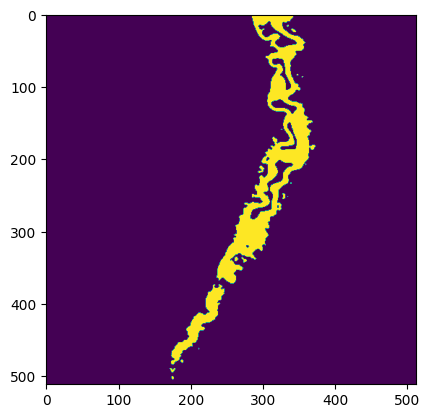

In [211]:
plt.imshow(binary_images_3[10])

In [212]:
x_3 = makepcl(binary_images_3)

In [213]:
compress_ratio(x_3, 'x_3')

0.0023058737083682668

In [214]:
octreeunzip('x_3_ocz.npz')

'Saved:x_3_ocz.xyz'

In [215]:
uncomp = o3d.io.read_point_cloud('x_3_ocz.xyz')
o3d.visualization.draw_geometries([uncomp])
# cloudPoints = np.asarray(cloud.points)

In [216]:
# o3d.visualization.draw_geometries([x_3])

In [217]:
np.array(uncomp.points[0])

array([-147.    ,  258.0625,    1.6562])

In [218]:
# for cls_img in closed_images:
#     # plt.imshow(bin_img, cmap='gray')
#     # plt.show()
#     cv2.imshow('binary image', cls_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [219]:
# # Create a mesh from the point cloud using alpha shape algorithm
# alpha = 5
# print(f"alpha={alpha:.3f}")
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(point_cloud, alpha)
# mesh.compute_vertex_normals()

- incorporate cylinders and knowledge of cylinders
- computer graphics and curvature
- 

In [220]:
# import networkx as nx
# from GraphRicciCurvature.OllivierRicci import OllivierRicci

# # First, you need to convert your 3D mesh into a NetworkX graph
# G = nx.Graph()

# # Add nodes to the graph
# for i, vertex in enumerate(mesh.vertices):
#     G.add_node(i, pos=vertex)

# # Add edges to the graph
# for triangle in mesh.triangles:
#     G.add_edge(triangle[0], triangle[1])
#     G.add_edge(triangle[1], triangle[2])
#     G.add_edge(triangle[2], triangle[0])

# # Compute Ricci curvature using the GraphRicciCurvature library
# orc = OllivierRicci(G, alpha=10, verbose="INFO")
# G_orc = orc.compute_ricci_curvature()

# from pydiffmap import diffusion_map as dm
# # from pydiffmap.kernel import VariableBandwidthKernel

# data = np.asarray(point_cloud.points)

# # Construct a Gaussian kernel object
# kernel_object = dm.kernel.Kernel(kernel_type='gaussian', epsilon='bgh')

# # Create an instance of the DiffusionMap class
# dmap = dm.DiffusionMap(kernel_object=kernel_object, n_evecs=3)

# # Compute the diffusion map
# dmap_data = dmap.fit_transform(data)

# from pydiffmap import visualization as vis

# vis.data_plot(dmap)